*   Classification

Dataset used in this notebook.: https://susanqq.github.io/UTKFace/

## 1) **Import libraries**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
import cv2
from tensorflow.keras.layers import *
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, r2_score

## 2) **Processing the data**

Create dataset_dict object to id/encode race and gender. We can use this to convert prediction label to text during evaluation.

In [2]:
# definitions for UTKDataset
dataset_dict ={
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}

dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())

Import UTKDataset and decode the labels for the purpose of visual analysis. We print the top 10 rows of the dataframe to preview the labels and data.

In [3]:
dir = './UTKDataset/UTKFace'

# Fraction of the dataset to be used for testing.
split = 0.3

image_data = []

def parse_data(filename):
  try:
    parts = filename.split('_')
    age = parts[0]
    gender = parts[1]
    race = parts[2]
    return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)], filename
  except Exception as e:
    return None, None, None, None

for i in os.listdir(dir):
  age, gender, race, filename = parse_data(i)
  if age is not None and gender is not None and race is not None and filename is not None:
    image_data.append(parse_data(i))

data = pd.DataFrame(image_data, columns=["age", "gender", "race", "filename"])
data = data.sample(frac=1).reset_index(drop=True) # shuffle dataframe in place and reset index
data.head(10)

,age,gender,race,filename
0,49,female,white,49_1_0_20170104192623743.jpg.chip.jpg
1,45,female,black,45_1_1_20170113195612333.jpg.chip.jpg
2,45,female,asian,45_1_2_20170107211934472.jpg.chip.jpg
3,22,female,black,22_1_1_20170114033236159.jpg.chip.jpg
4,28,male,white,28_0_0_20170117020857776.jpg.chip.jpg
5,20,female,indian,20_1_3_20170119180826861.jpg.chip.jpg
6,33,male,asian,33_0_2_20170119163942412.jpg.chip.jpg
7,27,female,white,27_1_0_20170117174845392.jpg.chip.jpg
8,38,male,white,38_0_0_20170104204524306.jpg.chip.jpg
9,47,male,others,47_0_4_20170105172754348.jpg.chip.jpg


We perform some observation on the dataset. Plot data distribution for each individual label.

In [4]:
def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
    
    fig.show()

In [5]:
plot_distribution(data['gender'])
plot_distribution(data['race'])

In [6]:
fig = px.histogram(data, x="age", nbins=20)
fig.update_layout(title_text='Age distribution on Train Dataset')
fig.show()

Face dataset generator. Generator class to perform preprocessing on dataset before trainig.

def preprocess_image:
- Perform image augmentation as necessary
- We also perform histogram equalization in this step

def alias:
- Associate labels with their numerical representation if necessary
- Get split index for train, validation and test

def generate_images:
- Load image from filename and labels to be used as training inputs and labels

In [4]:
img_height = 128
img_width = 128
split = 0.7 # train test split

class FaceDataGenerator():
  def __init__(self, dataframe):
    self.dataframe = dataframe

  def preprocess_image(self, file, equalize):
    imgs = cv2.imread(file)
    if equalize:
      imgs = cv2.cvtColor(imgs, cv2.COLOR_BGR2GRAY)
      imgs = cv2.equalizeHist(imgs)
    if imgs is not None:
      imgs = Image.fromarray(imgs)
      imgs = imgs.resize((img_width, img_height))
      imgs = np.array(imgs) / 255.0
    return imgs
  
  def alias(self):
    p = np.random.permutation(len(self.dataframe))
    train_up_to = int(len(self.dataframe) * split)
    train_idx = p[:train_up_to]
    test_idx = p[train_up_to:]
    train_up_to = int(train_up_to * split)
    train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
    self.dataframe['gender_id'] = self.dataframe['gender'].map(lambda gender: dataset_dict['gender_alias'][gender.strip()])
    self.dataframe['race_id'] = self.dataframe['race'].map(lambda race: dataset_dict['race_alias'][race])
    self.max_age = self.dataframe['age'].max()

    return train_idx, valid_idx, test_idx

  def generate_images(self, i_idx, is_training, batch_size=8, equalize=False):
    # arrays to store our batched data
    images, ages, races, genders = [], [], [], []
    while True:
      for idx in i_idx:
          person = self.dataframe.iloc[idx]
          
          age = person['age']
          race = person['race_id']
          gender = person['gender_id']
          filename = person['filename']
          
          im = self.preprocess_image(dir + '/' + filename, equalize)

          # if im is not None:
          images.append(im)
          
          ages.append(age / self.max_age)
          races.append(to_categorical(race, len(dataset_dict['race_id'])))
          genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
          
          # yielding condition
          if len(images) >= batch_size:
              yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
              images, ages, races, genders = [], [], [], []
          # else:
          #   self.dataframe.drop(idx)
              
      if not is_training:
          break



## 3) Model

Our aim is to develop a model that is small and fast enough while retaining enough accuracy and generalization.

* The model takes in a batch of shape `[ None , 128 , 128 , 3 ]` and performs a number of convolutions on it.

* The output from the convolution is fed to a dense layer flattened before passing out as 3 different outputs for the 3 labels we are predicting.


> See [this](https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/) blog for choosing the weight decay values used in the above two blocks.



### Model: Deep CNN Model

Deeper CNN Model proposed by V. Sheoran, S. Joshi, and T. R. Bhayani. The output layer is modified to make all 3 predictions at the same time while the input layer has a different shape to take in a 128x128 image size with grayscale.

Cite:

V. Sheoran, S. Joshi, and T. R. Bhayani, “Age and gender prediction using deep CNNs and transfer learning,” in Communications in Computer and Information Science, Singapore: Springer Singapore, 2021, pp. 293–304.

In [5]:
MODEL_INPUT_IMAGE_SIZE = [128, 128]

# Init a Input Layer.
inputs = tf.keras.layers.Input(shape=MODEL_INPUT_IMAGE_SIZE + [3])

#################### Combined Classifier #########################
x = inputs

x = SeparableConv2D(64, (3, 3), padding="same")(x)
x = Activation("relu")(x)
# x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3, 3))(x)

x = SeparableConv2D(128, (3, 3), padding="same")(x)
x = Activation("relu")(x)
# x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = SeparableConv2D(128, (3, 3), padding="same")(x)
x = Activation("relu")(x)
# x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = SeparableConv2D(256, (3, 3), padding="same")(x)
x = Activation("relu")(x)
# x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = SeparableConv2D(256, (3, 3), padding="same")(x)
x = Activation("relu")(x)
# x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

fc_input = x

x = Flatten()(fc_input)
x = Dense(128)(x)
x = Activation("relu")(x)
x = Dense(64)(x)
x = Activation("relu")(x)
x = Dense(32)(x)
# x = Dropout(0.5)(x)
gender = Dense(2, activation='sigmoid', name='gender_output')(x)

x = Flatten()(fc_input)
x = Dense(128)(x)
x = Activation("relu")(x)
x = Dense(64)(x)
x = Activation("relu")(x)
x = Dense(32)(x)
# x = Dropout(0.5)(x)
race = tf.keras.layers.Dense(5, activation='softmax', name='race_output')(x)

x = Flatten()(fc_input)
x = Dense(128)(x)
x = Activation("relu")(x)
x = Dense(64)(x)
x = Activation("relu")(x)
x = Dense(32)(x)
# x = Dropout(0.5)(x)
age = tf.keras.layers.Dense(1, activation='linear', name='age_output')(x)
#################### End of Combined Classifier ##################

# Build the Model
deeper_model = tf.keras.models.Model(inputs , [age, race, gender])

# Uncomment the below to view the summary of the model.
deeper_model.summary()
# tf.keras.utils.plot_model(model) # add to_file='architecture.png' to export architecture 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 128, 128, 64) 283         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           separable_conv2d[0][0]           
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 42, 42, 64)   0           activation[0][0]                 
______________________________________________________________________________________________

### Model: Our proposed model

This model performs separable convolutions on the input, resulting in lesser operations as compared to the previous model. Our goal is to reduce resource consumption and model size thus this method would be more favourable. We will compare the results of the training later to determine if it feasible to use this model.

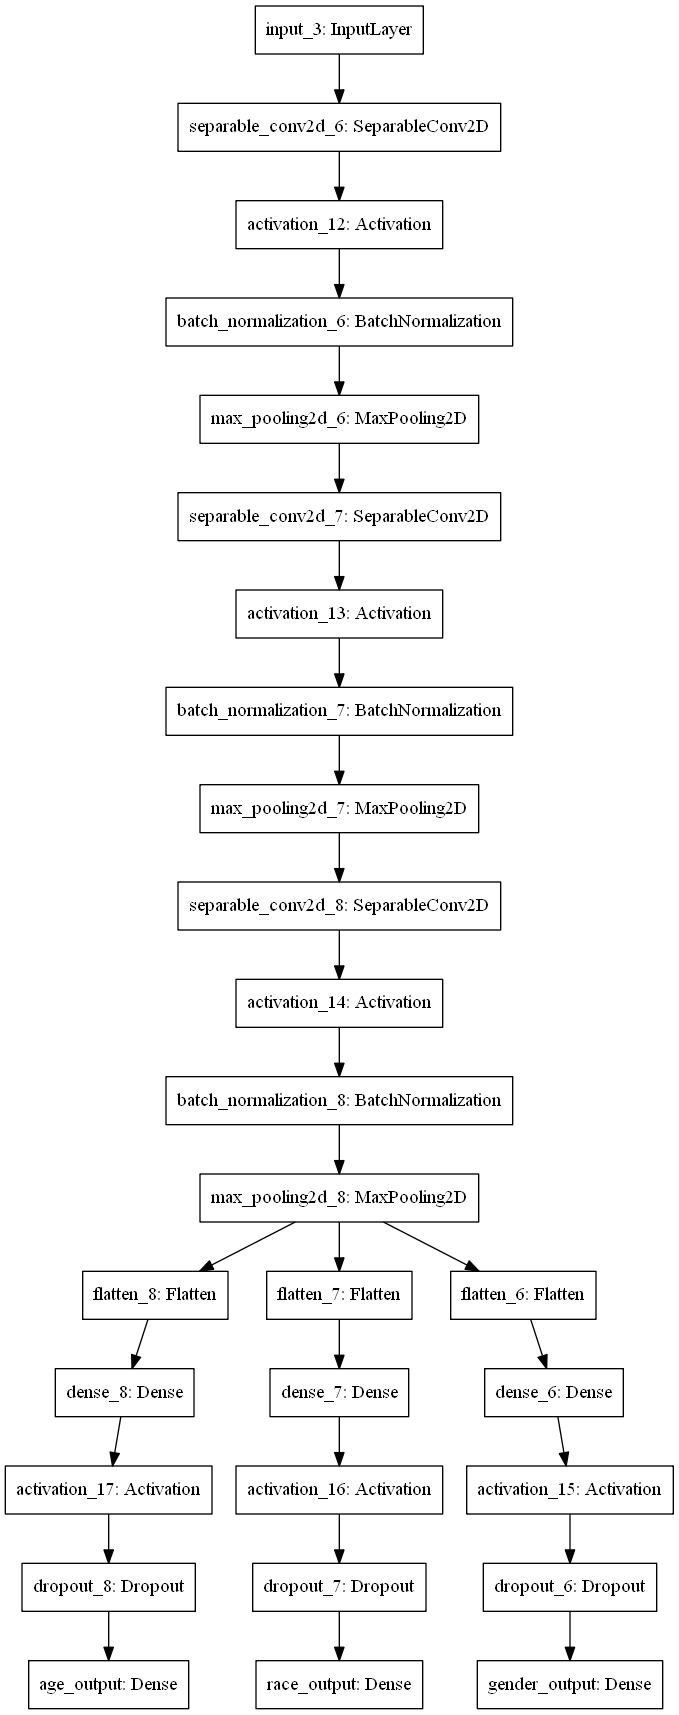

In [7]:
MODEL_INPUT_IMAGE_SIZE = [128, 128]

# Init a Input Layer.
inputs = tf.keras.layers.Input(shape=MODEL_INPUT_IMAGE_SIZE + [1])

#################### Combined Classifier #########################
x = inputs

x = SeparableConv2D(64, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(3, 3))(x)

x = SeparableConv2D(128, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = SeparableConv2D(256, (3, 3), padding="same")(x)
x = Activation("relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)


fc_input = x

x = Flatten()(fc_input)
x = Dense(128)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
gender = Dense(2, activation='sigmoid', name='gender_output')(x)

x = Flatten()(fc_input)
x = Dense(128)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
race = tf.keras.layers.Dense(5, activation='softmax', name='race_output')(x)

x = Flatten()(fc_input)
x = Dense(128)(x)
x = Activation("relu")(x)
x = Dropout(0.5)(x)
age = tf.keras.layers.Dense(1, activation='linear', name='age_output')(x)
#################### End of Combined Classifier ##################

# Build the Model
model_1 = tf.keras.models.Model(inputs , [age, race, gender])

# Uncomment the below to view the summary of the model.
# model_1.summary()
tf.keras.utils.plot_model(model_1) # add to_file='architecture.png' to export architecture 

## 4) Compiling the model


#### Callbacks:

* [`tf.keras.callbacks.ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) to save the Keras model as an H5 file after every epoch.

* [`tf.keras.callbacks.EarlyStopping`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) to stop the training when the evaluation metric i.e the MAE stops improving on the test dataset.

Early stopping is implemented to ensure that the model does not train more than necessary which could cause overfitting in the long run.

For the loss functions we chose differently depending on the labels we are predicting:
- Age: We will use mean squared error since age is a continuous value
- Race: We use categorical crossentropy since it is split into multiple different categories
- Gender: We use binary crossentropy since there is only 2 possible value for this label

In [9]:
model = model_1
model_type = 4
save_dir = './model-1'

In [6]:
model = deeper_model
model_type = 1
save_dir = './deeper-cnn'

In [10]:
learning_rate = 1e-5
num_epochs = 50 
batch_size = 32

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(save_dir)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
logdir = os.path.join("./logs/tb_logs" , datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

model.compile(
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=learning_rate,
        decay=learning_rate/num_epochs
    ),
    loss = {
        'age_output': 'mse',
        'race_output': 'categorical_crossentropy',
        'gender_output': 'binary_crossentropy'
    },
    metrics = {
        'age_output': 'mae',
        'race_output': 'accuracy',
        'gender_output': 'accuracy'
    }
)


## 5) Training the Model

Start the training loop with all callbacks packed in.


In [ ]:
# load tensorboard to view the training progress
%load_ext tensorboard
%tensorboard --logdir logs

In [11]:
# create generator object
generator = FaceDataGenerator(data)
train_idx, valid_idx, test_idx = generator.alias()
print(f'Training sample: {len(train_idx)}')
print(f'Validation sample: {len(valid_idx)}')
print(f'Testing sample: {len(test_idx)}')

if model_type <= 2:
    train_data = generator.generate_images(train_idx, is_training = True, batch_size = batch_size)
    test_data = generator.generate_images(valid_idx, is_training = True, batch_size = batch_size)
else:
# for model_1 and model_2
    train_data = generator.generate_images(train_idx, is_training = True, batch_size = batch_size, equalize=True)
    test_data = generator.generate_images(valid_idx, is_training = True, batch_size = batch_size, equalize=True)

# fit() supports generator as input
history = model.fit( 
    train_data,
    steps_per_epoch=len(train_idx)//batch_size,
    epochs=num_epochs,
    validation_data=test_data,
    validation_steps=len(valid_idx)//batch_size,
    verbose=1,
    callbacks=[checkpoint_callback , tensorboard_callback , early_stopping_callback]
)

Training sample: 11615
Validation sample: 4978
Testing sample: 7112
Epoch 1/50
362/362 [==============================] - 164s 445ms/step - loss: 2.6120 - age_output_loss: 0.5741 - race_output_loss: 1.4622 - gender_output_loss: 0.5758 - age_output_mae: 0.4675 - race_output_accuracy: 0.4533 - gender_output_accuracy: 0.7301 - val_loss: 4.6239 - val_age_output_loss: 1.6205 - val_race_output_loss: 2.3071 - val_gender_output_loss: 0.6962 - val_age_output_mae: 1.2607 - val_race_output_accuracy: 0.1641 - val_gender_output_accuracy: 0.4585
INFO:tensorflow:Assets written to: .\model-1\assets
Epoch 2/50
362/362 [==============================] - 37s 103ms/step - loss: 1.5726 - age_output_loss: 0.0537 - race_output_loss: 1.0958 - gender_output_loss: 0.4230 - age_output_mae: 0.1734 - race_output_accuracy: 0.5963 - gender_output_accuracy: 0.8095 - val_loss: 1.4455 - val_age_output_loss: 0.0443 - val_race_output_loss: 1.0151 - val_gender_output_loss: 0.3862 - val_age_output_mae: 0.1624 - val_race_ou

## 6) Evaluating the Model

In [12]:
# Overall Loss
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['loss'],
                    name='Train'))

fig.add_trace(go.Scattergl(
                    y=history.history['val_loss'],
                    name='Valid'))

fig.update_layout(height=500, 
                  width=700,
                  title='Overall loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')

fig.show()

Perform testing using the testing set

In [13]:
test_batch_size = 128
if model_type <= 2:
    test_generator = generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
else:
# for model_1 and model_2
    test_generator = generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size, equalize=True)
age_pred, race_pred, gender_pred = model.predict(test_generator, steps=len(test_idx)//test_batch_size)
if model_type <= 2:
    test_generator = generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
else:
# for model_1 and model_2
    test_generator = generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size, equalize=True)
samples = 0
images, age_true, race_true, gender_true = [], [], [], []
for test_batch in test_generator:
    image = test_batch[0]
    labels = test_batch[1]
    
    images.extend(image)
    age_true.extend(labels[0])
    race_true.extend(labels[1])
    gender_true.extend(labels[2])
    
age_true = np.array(age_true)
race_true = np.array(race_true)
gender_true = np.array(gender_true)

race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)

age_true = age_true * generator.max_age
age_pred = age_pred * generator.max_age

We evaluate the result of the testing on Race and Gender using precision recall.

In [14]:
cr_race = classification_report(race_true, race_pred, target_names=dataset_dict['race_alias'].keys())
print(cr_race)

              precision    recall  f1-score   support

       white       0.79      0.86      0.83      3003
       black       0.82      0.81      0.81      1341
       asian       0.74      0.80      0.77      1013
      indian       0.68      0.72      0.70      1186
      others       0.53      0.10      0.17       497

    accuracy                           0.77      7040
   macro avg       0.71      0.66      0.66      7040
weighted avg       0.75      0.77      0.75      7040



In [15]:
cr_gender = classification_report(gender_true, gender_pred, target_names=dataset_dict['gender_alias'].keys())
print(cr_gender)

              precision    recall  f1-score   support

        male       0.88      0.90      0.89      3632
      female       0.89      0.87      0.88      3408

    accuracy                           0.89      7040
   macro avg       0.89      0.89      0.89      7040
weighted avg       0.89      0.89      0.89      7040



We print the R2 score for Age prediction

In [16]:
print('R2 score for age: ', r2_score(age_true, age_pred))

R2 score for age:  0.63393075198346


We visualize some of the predictions made by the model

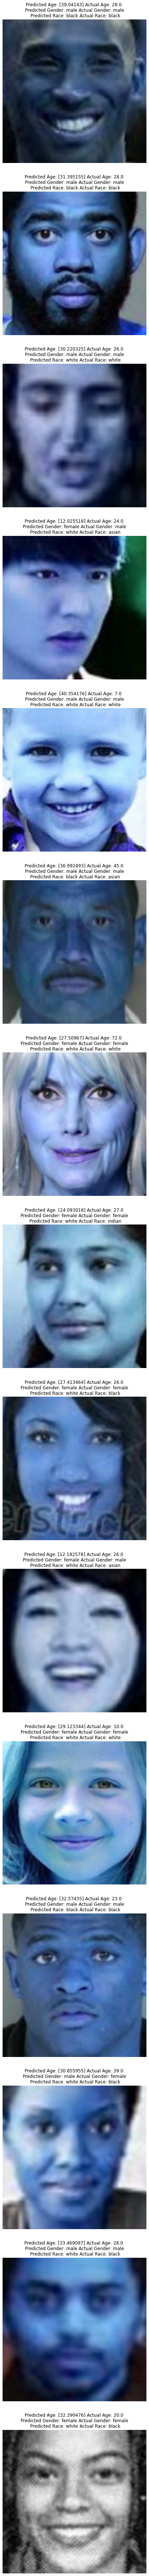

In [15]:
fig = plt.figure(figsize=(128, 128 ))
rows = 15
columns = 1

i = 1
for image , age_p, race_p, gender_p, age, race, gender in zip(images, age_pred, race_pred, gender_pred, age_true, race_true, gender_true):
    if i > 15:
        break
    image = np.array(image)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Predicted Age: {age_p} Actual Age: {age} \n Predicted Gender: {dataset_dict["gender_id"][gender_p]} Actual Gender: {dataset_dict["gender_id"][gender]} \n Predicted Race: {dataset_dict["race_id"][race_p]} Actual Race: {dataset_dict["race_id"][race]}')
    i += 1

 
## 7) Convert to TensorFlow Lite format

Our model can be deployed to edge devices such as Android phones or Raspberry Pi.

We will use the `TFLiteConverter` API to convert our Keras Model ( `.h5` ) to a TF Lite buffer ( `.tflite` ). We'll produce a TF Lite buffers with float16 quantization. This operation reduces model size by up to half as the weight values are converted to float16 values. This operation do cause a small drop in accuracy however.


In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model( model )
converter.optimizations = [ tf.lite.Optimize.DEFAULT ]
converter.target_spec.supported_types = [ tf.float16 ]
buffer = converter.convert()

model_name = 'CZ4042-model-lite'

open( '{}_q.tflite'.format( model_name ) , 'wb' ).write( buffer )
# files.download( '{}_q.tflite'.format( model_name ) )

INFO:tensorflow:Assets written to: C:\Users\Bambi\AppData\Local\Temp\tmpp_swe07g\assets


INFO:tensorflow:Assets written to: C:\Users\Bambi\AppData\Local\Temp\tmpp_swe07g\assets


837888


For conversion to a non-quantized TF Lite buffer.


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model( model )
buffer = converter.convert()

open( '{}_nonq.tflite'.format( model_name ) , 'wb' ).write( buffer )
files.download( '{}_nonq.tflite'.format( model_name ) )